In [25]:
import pandas as pd
from nltk.corpus import stopwords
from tools import *
import nltk.data
from collections import Counter
#nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [2]:
data_sig = pd.read_csv('cleaned_data/signal_clean_text.csv')

In [3]:
data_sig = data_sig.dropna()
data_sig.reset_index(drop=True, inplace=True)
## split into sentences
data_sig['sent'] = data_sig['text'].apply(lambda x: [j for i in x.split('\n') 
                                          for j in tokenizer.tokenize(i)])

In [4]:
## token each sentences
sent_token = []
max_len = data_sig.shape[0]
for ind, txt in enumerate(data_sig['sent']):
    print(round(ind/max_len, 4), end = '\r')
    sent_token.append([normalizeTokens(i) for i in txt])

In [5]:
data_sig['sent_token'] = sent_token
data_sig['word_token'] = data_sig['sent_token'].apply(lambda x: [j for i in x for j in i])

In [7]:
data_sig['Year'] = data_sig['date'].apply(lambda x: x[:4])

In [16]:
data_sig.to_csv('cleaned_data/signal_clean_text.csv', index=False)

In [21]:
data_sig['ind'] = data_sig.index
data_sig['ind'] = data_sig['ind'].apply(lambda x: 'sig'+str(x))
data_sig = data_sig[['ind', 'category', 'Year', 'text', 'sent_token', 'word_token']]

In [27]:
category_dict = {
    'topics-economy': 'economy',
    'topics-society': 'society',
    'topics-law': 'law',
    'politics-topics': 'politics',
    'topics-health-care': 'health'
}

In [31]:
data_sig['category'] = data_sig['category'].apply(lambda x: category_dict[x]
                                                if x in category_dict else x)

In [117]:
data_sig.to_csv('data/signal_token.csv', index=False)

## Primary

In [41]:
data_sig.head()

,ind,category,Year,text,sent_token,word_token
0,sig0,economy,2020,Entrepreneurs have been unleashed inside bligh...,"[[entrepreneur, unleash, inside, blight, commu...","[entrepreneur, unleash, inside, blight, commun..."
1,sig1,economy,2020,Small and midsize online stores are being put ...,"[[small, midsize, online, store, business, tax...","[small, midsize, online, store, business, tax,..."
2,sig2,economy,2020,It seems that Sen. Bernie Sanders can always f...,"[[sen, bernie, sander, find, way, look, bright...","[sen, bernie, sander, find, way, look, bright,..."
3,sig3,economy,2020,When the Environmental\nProtection Agency issu...,"[[environmental], [protection, agency, issue, ...","[environmental, protection, agency, issue, reg..."
4,sig4,economy,2020,Fiscal responsibility is key to draining the s...,"[[fiscal, responsibility, key, drain, swamp, w...","[fiscal, responsibility, key, drain, swamp, wh..."


In [43]:
import sklearn

In [42]:
Counter(data_sig['Year'])

Counter({'2020': 538,
         '2019': 3263,
         '2018': 3432,
         '2017': 2901,
         '2016': 2596,
         '2015': 4224,
         '2014': 3889,
         '2013': 1725,
         '2012': 1478,
         '2011': 1474,
         '2010': 1940,
         '2009': 2004,
         '2008': 1009})

In [44]:
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, 
                                                                 max_features=1000, min_df=3, 
                                                                 stop_words='english', 
                                                                 norm='l2')
groupsTFVects = ngTFVectorizer.fit_transform(data_sig['text'])
print(groupsTFVects.shape)

(30473, 1000)


In [45]:
list(zip(ngTFVectorizer.vocabulary_.keys(), groupsTFVects.data))[:20]

[('communities', 0.04196921745941099),
 ('bring', 0.02278326605681951),
 ('economic', 0.03672331995791842),
 ('opportunity', 0.04563098377153187),
 ('needed', 0.07943908807635801),
 ('donald', 0.04375420976956592),
 ('trump', 0.04335936297400807),
 ('administration', 0.03816800970666034),
 ('officials', 0.035452689343234686),
 ('said', 0.04779336297330594),
 ('friday', 0.042476476609781946),
 ('executive', 0.030202809393167083),
 ('director', 0.03801990137786365),
 ('white', 0.05188603301326796),
 ('house', 0.08091262904808774),
 ('council', 0.07666861570938034),
 ('progress', 0.03945338855986909),
 ('environmental', 0.043019687754804505),
 ('protection', 0.03787670175709556),
 ('agency', 0.04109053245630346)]

In [46]:
import gensim#For topic modeling

In [48]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

data_sig['reduced_tokens'] = data_sig['word_token'].apply(lambda x: 
                             dropMissing(x, ngTFVectorizer.vocabulary_.keys()))
dictionary = gensim.corpora.Dictionary(data_sig['reduced_tokens'])
corpus = [dictionary.doc2bow(text) for text in data_sig['reduced_tokens']]

In [49]:
gensim.corpora.MmCorpus.serialize('signal.mm', corpus)
senmm = gensim.corpora.MmCorpus('signal.mm')

In [50]:
num_topics=6
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, 
                                         num_topics=num_topics, alpha='auto', eta='auto')

In [51]:
ldaDF = pandas.DataFrame({
        'category' : data_sig['category'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in data_sig['reduced_tokens']]})

topicsProbDict = {i:[0] * len(ldaDF) for i in range(senlda.num_topics)}

for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

for topicNum in range(senlda.num_topics):
    topic_name = f'topic_{topicNum}'
    ldaDF[topic_name] = topicsProbDict[topicNum]
    
ldaDF = ldaDF.groupby(['category']).mean()

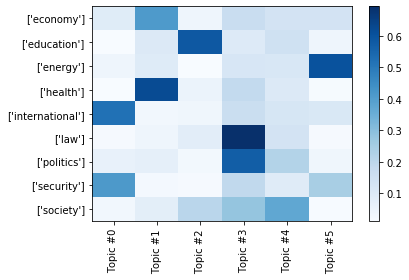

In [52]:
N = ldaDF.shape[0]
ldaDFV = ldaDF[:N][['topic_%d' %x for x in range(num_topics)]]
ldaDFVisN = pd.DataFrame(ldaDF[:N].index)
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
topic_labels = ['Topic #{}'.format(k) for k in range(senlda.num_topics)]
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);
# flip the y-axis so the texts are in the order we anticipate
plt.gca().invert_yaxis()
plt.xticks(rotation=90)
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

In [53]:
#the top words from each topic to get a sense 
#of the semantic (or syntactic) domain they represent
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5
0,war,plan,marriage,say,people,defense
1,military,welfare,child,court,say,missile
2,security,percent,religious,law,woman,obama
3,attack,health,state,state,life,state
4,force,spend,school,house,time,administration
5,country,care,sex,trump,think,nuclear
6,world,parenthood,family,vote,like,year
7,iran,year,law,obama,year,north
8,state,program,government,senate,man,program
9,terrorist,reform,program,case,live,treaty


In [54]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(groupsTFVects.toarray())
reduced_data = pca.transform(groupsTFVects.toarray())

In [57]:
reduced_data.shape

(30473, 2)

In [59]:
cat = set(data_sig['category'])
cat_dict = dict(zip(cat, range(len(cat))))
color = data_sig['category'].apply(lambda x: cat_dict[x])

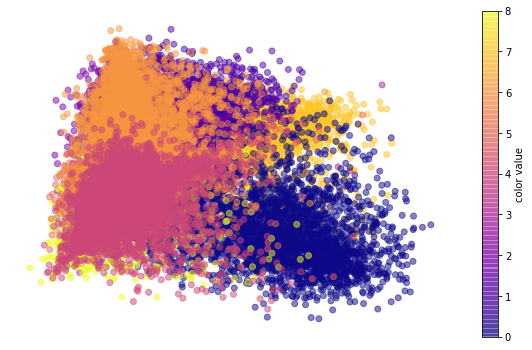

In [75]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], 
            c=color, cmap=plt.get_cmap('plasma'), 
            alpha = 0.5)
plt.xticks(()); plt.yticks(())
plt.colorbar(ticks=range(len(cat)), label='color value')
plt.show()

In [79]:
cat_dict

{'health': 0,
 'energy': 1,
 'international': 2,
 'education': 3,
 'society': 4,
 'politics': 5,
 'security': 6,
 'economy': 7,
 'law': 8}

In [99]:
text = data_sig['sent_token'].sum()
words_W2V = gensim.models.word2vec.Word2Vec(text)
#words_W2V.save("unnormalized_data_WORD2Vec")

In [100]:
words_W2V.most_similar('people')

[('americans', 0.7228679656982422),
 ('folk', 0.6982751488685608),
 ('person', 0.6969841718673706),
 ('citizen', 0.6371272206306458),
 ('somebody', 0.600993275642395),
 ('everybody', 0.5869215130805969),
 ('adult', 0.5617939233779907),
 ('ukrainians', 0.5617499947547913),
 ('individual', 0.5612215995788574),
 ('worker', 0.5525540113449097)]

In [109]:
def makeDF(model, word_list):

    r = []
    c = []
    i = []
    for word in word_list:

        r.append(sklearn.metrics.pairwise.cosine_similarity(words_W2V[word].reshape(1,-1), 
                                                            Race.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(words_W2V[word].reshape(1,-1), 
                                                            Class.reshape(1,-1))[0][0])
        i.append(sklearn.metrics.pairwise.cosine_similarity(words_W2V[word].reshape(1,-1), 
                                                            Ideology.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'race': r, 'class': c, 'ideology': i}, index = word_list)
    return df

In [114]:
def dimension(model, words):
    dim = sum([normalize(model[x]) for x in words])
    return dim

def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

#Gender = dimension(words_W2V, ['man','he'], ['woman', 'she'])
Race = dimension(words_W2V, [])
Class = dimension(words_W2V, ['rich', 'expensive', 'wealthy'], 
                             ['poor', 'cheap', 'inexpensive'])

Ideology = dimension(words_W2V, ['conservative', 'liberalism', 'republicanism', 'republican'],
                                ['liberal', 'progressive', 'progressivism', 'democrat'])

Occupations = ["doctor","lawyer", "plumber", "scientist", "nanny",
               "entrepreneur","writer", "banker","poet","nurse", "politician",
               'worker', 'driver']
people  = ['trump', 'bush', 'obama', 'clinton', 'reagan', 'carter', 'ford', 'nixon', 'truman']

In [116]:
Race

array([-0.04840857, -0.28493676, -0.03264087,  0.1409488 , -0.02763925,
       -0.24921852,  0.10677728, -0.01698001,  0.07633042, -0.3193876 ,
       -0.04039415, -0.13310343, -0.00654218, -0.24029735,  0.20207386,
       -0.0008524 ,  0.17643937,  0.16687597, -0.30467933,  0.22521554,
        0.3177048 , -0.00477134,  0.09230097,  0.06197882, -0.00233538,
        0.10694906, -0.35323718, -0.02373412, -0.04173459,  0.2740448 ,
       -0.28793627, -0.15923467,  0.11793713, -0.03596231,  0.31309962,
        0.1826163 , -0.22565053,  0.03081587,  0.26991248,  0.29196906,
       -0.30459696, -0.18198755,  0.5007719 , -0.03075954,  0.05291033,
        0.07547734,  0.06985578,  0.05498347, -0.29762205, -0.08953373,
        0.06038758, -0.17258629,  0.20754224, -0.08344041,  0.04313903,
       -0.30584767, -0.13227874,  0.01380809, -0.06042986,  0.13371444,
       -0.20203364,  0.07485341, -0.11412385,  0.04713167, -0.0369941 ,
        0.1849756 , -0.20302755,  0.37644392,  0.1268573 , -0.01

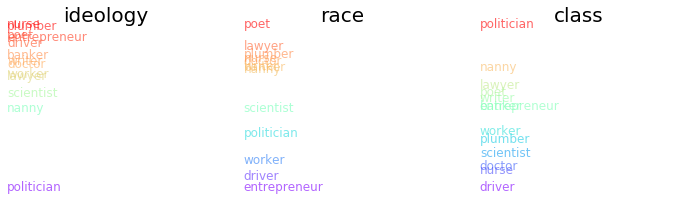

In [115]:
OCCdf = makeDF(words_W2V, Occupations) 

fig = plt.figure(figsize = (12,3))

ax1 = fig.add_subplot(131)
PlotDimension(ax1, OCCdf, 'ideology')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, OCCdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, OCCdf, 'class')

plt.show()